In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [2]:
INPUT_DATA_DIR = '../../data/processed/'
INPUT_FILE_NAME = 'squashed_processed_data.pkl'

In [3]:
df = pd.read_pickle(INPUT_DATA_DIR + INPUT_FILE_NAME)
df.head()

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,harm_vice,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general
0,1,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2,2006,TED2006,0:16:17,...,0.04,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22
1,2,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2,2006,TED2006,0:15:06,...,0.04,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15
2,3,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7,2005,TEDGlobal 2005,0:18:45,...,0.12,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08
3,4,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2,2006,TED2006,0:19:37,...,0.19,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16
4,5,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2,2002,TED2002,0:20:04,...,0.05,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
#                         min_df = 0.05,     # cut words present in less than 5% of documents
                        max_df = 0.3)      # cut words present in more than 30% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(df['transcript'])
print("done in %0.3fs." % (time() - t0))

done in 1.368s.


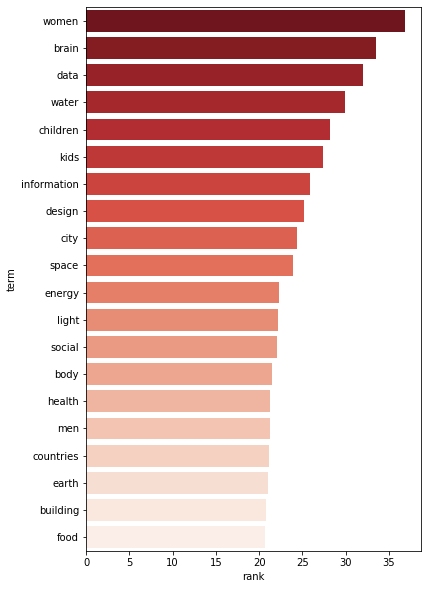

In [5]:
# Let's make a function to call the top ranked words in a vectorizer
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

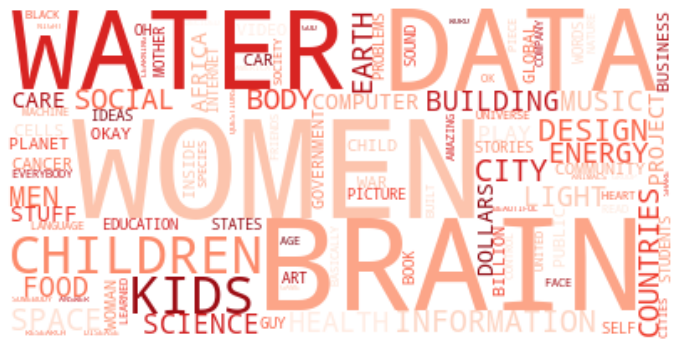

In [6]:
# Let's visualize a word cloud with the frequencies obtained by idf transformation
dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='Reds').generate_from_frequencies(dic)
fig = plt.figure(1,figsize=(12,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [7]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 30
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['marshmallow', 'passwords', 'mahmoud', 'archimedes', 'password'],
 1: ['autism', 'autistic', 'disorders', 'dopamine', 'nigerian'],
 2: ['hum', 'hallucinations', 'everglades', 'anas', 'humanae'],
 3: ['crispr', 'yo', 'bonica', 'dm', 'jf'],
 4: ['higgs', 'js', 'bees', 'honeybees', 'oyster'],
 5: ['heh', 'sanitary', 'cemeteries', 'trailer', 'affair'],
 6: ['cybercriminals', 'redemption', 'phantom', 'np', 'visicalc'],
 7: ['ts', 'cyrus', 'fgm', 'twentysomethings', 'superconductor'],
 8: ['genome', 'pages', 'dinner', 'illness', 'microbes'],
 9: ['edi', 'neurogenesis', 'towel', 'tapirs', 'sweeney'],
 10: ['sexting', 'epilepsy', 'guerrillas', 'alzheimers', 'lg'],
 11: ['phosphorus', 'sw', 'tattoos', 'ivan', 'doo'],
 12: ['civil', 'films', 'capitalism', 'factor', 'beach'],
 13: ['locomotion', 'gecko', 'pete', 'bf', 'td'],
 14: ['stasi', 'doaa', 'fibonacci', 'dough', 'veronica'],
 15: ['mosquitos', 'ss', 'ynh', 'cricket', 'dcima'],
 16: ['ja', 'alec', 'tourism', 'goliath', 'entropica'],
 1

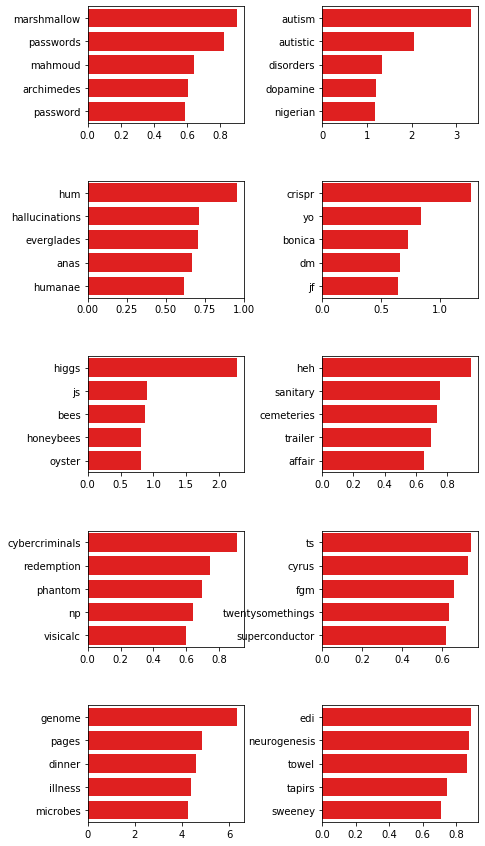

In [8]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [9]:
from sklearn.decomposition import NMF

n_topics = 50
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words


{0: ['oh', 'yeah', 'okay', 'father', 'mother'],
 1: ['women', 'men', 'woman', 'sex', 'gender'],
 2: ['patients', 'health', 'care', 'patient', 'medical'],
 3: ['cancer', 'tumor', 'drug', 'pancreatic', 'breast'],
 4: ['water', 'river', 'drinking', 'waste', 'sanitation'],
 5: ['universe', 'galaxies', 'galaxy', 'stars', 'space'],
 6: ['brain', 'neurons', 'brains', 'cortex', 'neuron'],
 7: ['city', 'cities', 'building', 'buildings', 'space'],
 8: ['materials', '3d', 'building', 'material', 'architecture'],
 9: ['students', 'education', 'teachers', 'learning', 'teacher'],
 10: ['dna', 'genome', 'genes', 'bacteria', 'genetic'],
 11: ['robot', 'robots', 'robotics', 'locomotion', 'romo'],
 12: ['music', 'play', 'musical', 'orchestra', 'classical'],
 13: ['africa', 'african', 'continent', 'africans', 'aid'],
 14: ['iran', 'arab', 'muslim', 'muslims', 'islam'],
 15: ['growth', 'countries', 'economic', 'income', 'economy'],
 16: ['data', 'map', 'numbers', 'information', 'web'],
 17: ['climate', 'e

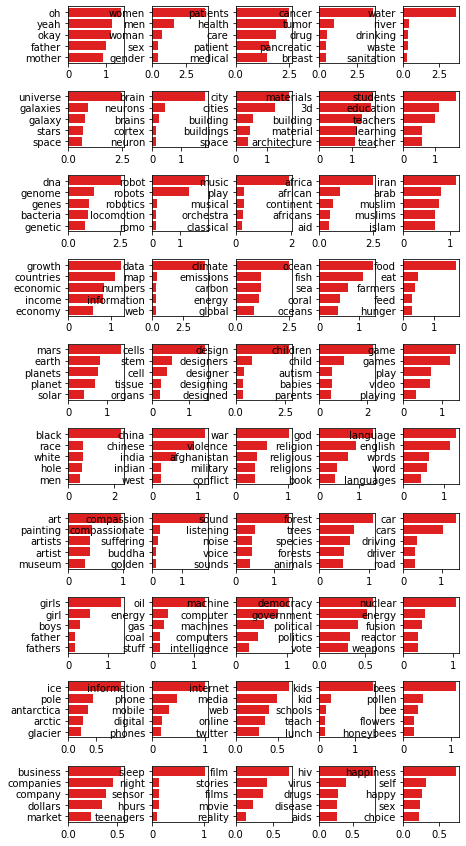

In [10]:
fig, ax = plt.subplots(figsize=(7,15), ncols=5, nrows=10)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,10):
    for col in range(0,5):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [11]:
# Formulating a pipeline to insert a document and extract the topics pertinency
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

# take second element for sort
def takeSecond(elem):
    return elem[1]

def predict_best_topics_processed_string(string):
    t = pipe.transform([string])
    rev_topics = np.where(t>0.01)[1]
    rev_topics_score = t[0][rev_topics]

    rev_topscore = list(zip(rev_topics,rev_topics_score))
    rev_topscore.sort(key = takeSecond, reverse = True)
    return rev_topscore

def predict_best_topics_doc(did):
    string = df['transcript'].iloc[did]
    
    return predict_best_topics_processed_string(string)

In [12]:
def show_best_topics_doc(did):

    print('For document #'+str(did)+'...')

    rev_topscore = predict_best_topics_doc(did)
    
    print('\nAll relevant topics (in order of descending relevance): \n')
    for top in range(len(rev_topscore)):
        print(t_words[rev_topscore[top][0]])

    print('\nTranscript:\n',df['transcript'].iloc[document_id][:500],'...')
    print('\nTrue tags from ted_main.csv: \n',df['tags'].iloc[document_id])

In [13]:
show_best_topics(1571)

NameError: name 'show_best_topics' is not defined

In [15]:
correct = 0
total = len(df.index)
all_tags = []
for tr in range(total):
    #print(tr)
    rev_topscore = predict_best_topics_doc(tr)
    if rev_topscore != []: 
        topic_tags = t_words[rev_topscore[0][0]]
        given_tags = df['tags'][tr]
    #     print(topic_tags)
    #     print(given_tags)
        for label in given_tags:
            if label not in all_tags:
                all_tags.append(label)
        
        for word in topic_tags:
            if word in given_tags:
                correct += 1


print('Correct', correct)
percentage_correct = (correct/len(all_tags))
print('Percentage correct',percentage_correct)

Correct 1573
Percentage correct 54.241379310344826


In [16]:
def show_best_topics_string(string):
    print('For string:',string)

    rev_topscore = predict_best_topics_processed_string(string)
    
    print('\nAll relevant topics (in order of descending relevance): \n')
    for top in range(len(rev_topscore)):
        print(t_words[rev_topscore[top][0]])

In [17]:
your_input = input()
show_best_topics_string(your_input)

 hihi


For string: hihi

All relevant topics (in order of descending relevance): 



In [18]:
def predict_tags(re)

SyntaxError: invalid syntax (<ipython-input-18-33df1ae02d05>, line 1)